# Fan Sentiment vs Transfer Activity in the Premier League (Summer 2020)
This notebook analyzes how Premier League clubs' transfer activity
shapes fan sentiment on Twitter during the 2020 summer transfer window.

# We use:
A tweet dataset (with precomputed VADER sentiment scores),
Transfer data scraped from Wikipedia,
A bipartite fan–club network,
A self-trained sentiment model (Logistic Regression on TF-IDF),
Comparisons between the built-in VADER sentiment and our model.

In [1]:
import os
import re
from io import StringIO
from collections import Counter, defaultdict
from itertools import combinations

import kagglehub
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# For VADER lexicon comparison
# If not installed, uncomment and run the next line ONCE:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use("default")

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load tweet dataset from Kaggle

We use the "EPL Teams Twitter Sentiment Dataset" from Kaggle.
It contains tweets mentioning Premier League clubs with precomputed
VADER sentiment scores ("polarity" = compound score in [-1, 1]).

In [2]:
path = kagglehub.dataset_download("wjia26/epl-teams-twitter-sentiment-dataset")
print("Path to dataset files:", path)

# Load both CSV files
csv1 = os.path.join(path, "2020-07-09 till 2020-09-19.csv")
csv2 = os.path.join(path, "2020-09-20 till 2020-10-13.csv")
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Combine into one DataFrame and keep relevant columns
df = pd.concat([df1, df2], ignore_index=True)
df = df[['created_at', 'file_name', 'username', 'text', 'retweet_count', 'polarity']]
df.columns = ['date', 'club', 'user', 'text', 'retweets', 'sentiment']  # 'sentiment' = VADER compound

print("Raw tweet data shape:", df.shape)
df.head()

Path to dataset files: /Users/christofferfrost/.cache/kagglehub/datasets/wjia26/epl-teams-twitter-sentiment-dataset/versions/2
Raw tweet data shape: (1010582, 6)


,date,club,user,text,retweets,sentiment
0,2020-07-09 11:34:08,Liverpool,Liverpool FC News,This is a strange claim #LFC https://t.co/U1...,0,-0.2023
1,2020-07-09 11:33:52,Liverpool,Ged Smith,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,65,0.8316
2,2020-07-09 11:33:52,Liverpool,DADA BA♐,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,32,0.8793
3,2020-07-09 11:33:50,Liverpool,Ruairi Nolan,Outrageous... Poor auld Martin Tyler has to ju...,0,-0.6808
4,2020-07-09 11:33:31,Liverpool,🇮🇪 David D'Arcy 🇮🇪,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,176,0.8176


# 2. Scrape transfer data from Wikipedia

We use the "List of English football transfers summer 2020" Wikipedia page.
Steps:
1. Download HTML (with User-Agent to avoid 403),
2. Keep only transfer-like tables,
3. Clean column names,
4. Filter to the same window as the tweets (27 July – 11 September 2020),
5. Keep only 20/21 Premier League clubs,
6. Parse transfer fees into million GBP and compute club-level spend.

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_English_football_transfers_summer_2020"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()
html = response.text

tables = pd.read_html(StringIO(html))
print(f"Total tables found on Wikipedia page: {len(tables)}")

# Keep only "transfer-like" tables (with date, from, to)
valid_tables = []
for t in tables:
    cols = [str(c).lower() for c in t.columns]
    has_date = any("date" in c for c in cols)
    has_from = any("from" in c for c in cols)
    has_to   = any("to"   in c for c in cols)
    if has_date and has_from and has_to:
        valid_tables.append(t)

print(f"Transfer-like tables kept: {len(valid_tables)}")

# Combine and drop completely empty columns
transfers_df = pd.concat(valid_tables, ignore_index=True)
transfers_df = transfers_df.dropna(axis=1, how="all")

# Standardise column names
rename_map = {}
date_assigned   = False
player_assigned = False
from_assigned   = False
to_assigned     = False
fee_assigned    = False

for c in transfers_df.columns:
    cl = str(c).lower()
    if ("date" in cl) and not date_assigned:
        rename_map[c] = "Date"
        date_assigned = True
    elif ("player" in cl) and not player_assigned:
        rename_map[c] = "Player"
        player_assigned = True
    elif ("from" in cl) and not from_assigned:
        rename_map[c] = "From club"
        from_assigned = True
    elif ("to" in cl) and not to_assigned:
        rename_map[c] = "To club"
        to_assigned = True
    elif ("fee" in cl) and not fee_assigned:
        rename_map[c] = "Fee"
        fee_assigned = True

transfers_df = transfers_df.rename(columns=rename_map)
transfers_df = transfers_df.loc[:, ~transfers_df.columns.duplicated()]

keep_cols = [c for c in ["Date", "Player", "From club", "To club", "Fee"] if c in transfers_df.columns]
transfers_df = transfers_df[keep_cols].copy()

print("Columns after cleaning:", transfers_df.columns.tolist())
print("Total raw transfer rows:", len(transfers_df))

# Parse dates & filter to same window as tweets
transfers_df["Date"] = pd.to_datetime(transfers_df["Date"], dayfirst=True, errors="coerce")
transfers_df = transfers_df.dropna(subset=["Date"])

start_date = "2020-07-27"
end_date   = "2020-09-11"
mask_dates = (transfers_df["Date"] >= start_date) & (transfers_df["Date"] <= end_date)
window_df = transfers_df[mask_dates].copy()

print("Transfer rows in date window:", len(window_df))

# Keep only 20/21 Premier League clubs (subset used in tweet data)
pl_clubs = {
    "Arsenal",
    "Manchester United",
    "Liverpool",
    "Manchester City",
    "Tottenham Hotspur",
    "Everton",
    "Chelsea",
    "Crystal Palace",
    "Leicester City",
    "Southampton",
    "Burnley",
}

mask_pl = window_df["From club"].isin(pl_clubs) | window_df["To club"].isin(pl_clubs)
pl_transfers = window_df[mask_pl].copy()
print("Transfer rows involving PL clubs:", len(pl_transfers))

# Function to parse fee strings -> million GBP
def parse_fee_to_million_gbp(fee_str):
    if pd.isna(fee_str):
        return np.nan
    s = str(fee_str).lower().strip()
    if any(w in s for w in ["loan", "free", "undisclosed", "end of loan", "released"]):
        return 0.0
    s_clean = s.replace(",", "")
    m = re.search(r"£\s*([\d\.]+)\s*(m|million)", s_clean)
    if m:
        return float(m.group(1))
    k = re.search(r"£\s*([\d\.]+)\s*(k|thousand)", s_clean)
    if k:
        return float(k.group(1)) / 1000.0
    n = re.search(r"£\s*([\d\.]+)", s_clean)
    if n:
        return float(n.group(1)) / 1_000_000.0
    return np.nan

pl_transfers["Fee_clean_mGBP"] = pl_transfers["Fee"].apply(parse_fee_to_million_gbp)

# Compute gross spend (only incoming transfers to PL clubs)
pl_buys = pl_transfers[pl_transfers["To club"].isin(pl_clubs)].copy()
club_spend = (
    pl_buys.groupby("To club")["Fee_clean_mGBP"]
    .sum()
    .sort_values(ascending=False)
)

print("\nTotal gross spend (million GBP):")
print(club_spend)

# Save transfer data to CSV (used later when merging)
pl_transfers.to_csv("pl_transfers_2020-07-27_to_2020-09-11.csv", index=False)
club_spend.to_csv("pl_club_spend_2020-07-27_to_2020-09-11.csv")
print("\nSaved transfer CSVs.")

Total tables found on Wikipedia page: 4
Transfer-like tables kept: 2
Columns after cleaning: ['Date', 'From club', 'To club', 'Fee']
Total raw transfer rows: 819
Transfer rows in date window: 361
Transfer rows involving PL clubs: 55

Total gross spend (million GBP):
To club
Chelsea              116.00
Manchester City       61.87
Everton               53.70
Manchester United     35.00
Arsenal               27.00
Leicester City        25.00
Southampton           22.90
Crystal Palace        19.50
Tottenham Hotspur     15.00
Liverpool             11.75
Burnley                0.00
Name: Fee_clean_mGBP, dtype: float64

Saved transfer CSVs.


# 3. Clean tweet data and restrict to transfer window

We restrict to the same no-match transfer window:

27 July 2020 – 11 September 2020, i.e. when there are transfers but no games.

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['club', 'user', 'text'])

start = pd.to_datetime("2020-07-27")
end   = pd.to_datetime("2020-09-11")
df = df[(df['date'] >= start) & (df['date'] <= end)].copy()

print(f"Filtered tweet dataset (no matches): {len(df):,} rows, {df.shape[1]} columns")
print(f"Size in memory: {round(df.memory_usage(deep=True).sum() / 1e6, 2)} MB")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Unique clubs: {df['club'].nunique()}")
print("\nTweets per club:")
print(df['club'].value_counts())

Filtered tweet dataset (no matches): 446,475 rows, 6 columns
Size in memory: 243.79 MB
Date range: 2020-07-27 00:00:02 → 2020-09-10 23:59:55
Unique clubs: 12

Tweets per club:
club
Arsenal             79993
ManchesterUnited    78916
Liverpool           74239
ManchesterCity      50385
TottenhamHotspur    45118
Everton             35186
Chelsea             21931
CrystalPalace       21356
LeicesterCity       20254
Southampton          9456
AFC Bournemouth      6144
Burnley              3497
Name: count, dtype: int64


# 4. Build fan–club bipartite network

- Nodes: users (fans) and clubs
- Edges: user tweeted about club (weighted by number of tweets)

In [5]:
G = nx.Graph()
for user, club in df[['user', 'club']].itertuples(index=False):
    if pd.isna(user) or pd.isna(club):
        continue
    G.add_node(user, bipartite='fan')
    G.add_node(club, bipartite='club')
    if G.has_edge(user, club):
        G[user][club]['weight'] += 1
    else:
        G.add_edge(user, club, weight=1)

fans = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'fan']
clubs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'club']

print("\nNETWORK OVERVIEW (no-match transfer window)")
print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Fans: {len(fans):,} | Clubs: {len(clubs):,}")
print(f"Edges (fan ↔ club): {G.number_of_edges():,}")


NETWORK OVERVIEW (no-match transfer window)
Total nodes: 127,138
Fans: 127,126 | Clubs: 12
Edges (fan ↔ club): 162,015


# 5. Club-level sentiment (VADER, from dataset)

We start with the precomputed VADER sentiment (`sentiment`) and compute
average sentiment and engagement per club.


Top clubs by tweet count (VADER sentiment):
                club  tweets  avg_sentiment  avg_retweets
1            Arsenal   79993       0.225329    201.126049
9   ManchesterUnited   78916       0.229009    320.193700
7          Liverpool   74239       0.271429    133.192204
8     ManchesterCity   50385       0.213904    450.954133
11  TottenhamHotspur   45118       0.211563    275.350060
5            Everton   35186       0.270679    106.048428
3            Chelsea   21931       0.194625    135.298390
4      CrystalPalace   21356       0.214788    116.098989
6      LeicesterCity   20254       0.187106    121.808680
10       Southampton    9456       0.220887     39.965842
0    AFC Bournemouth    6144       0.243267     22.740723
2            Burnley    3497       0.200182      8.164999


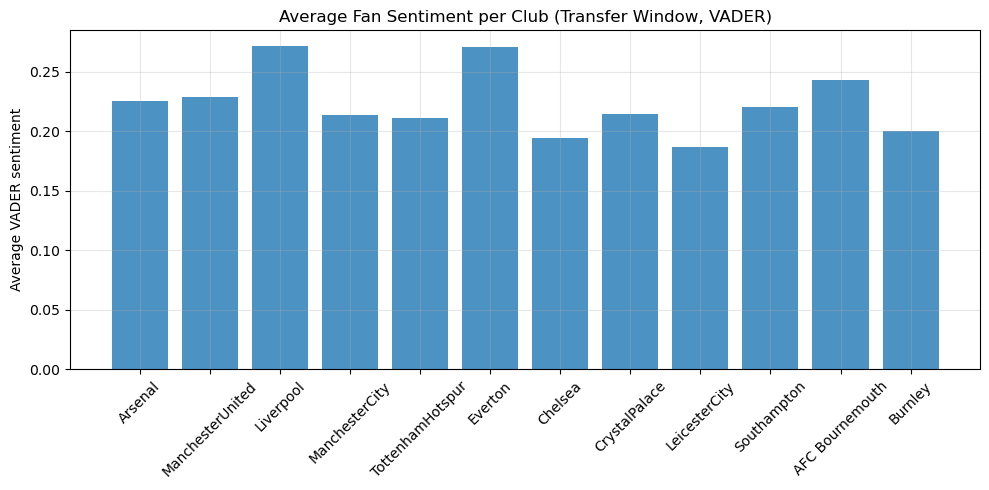

In [6]:
club_sent = df.groupby('club', as_index=False).agg(
    tweets=('text', 'count'),
    avg_sentiment=('sentiment', 'mean'),
    avg_retweets=('retweets', 'mean')
).sort_values('tweets', ascending=False)

print("\nTop clubs by tweet count (VADER sentiment):")
print(club_sent.head(12))

plt.figure(figsize=(10,5))
plt.bar(club_sent['club'], club_sent['avg_sentiment'], alpha=0.8)
plt.xticks(rotation=45)
plt.ylabel("Average VADER sentiment")
plt.title("Average Fan Sentiment per Club (Transfer Window, VADER)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Merge club sentiment with transfer spend

We now combine the club-level tweet sentiment with club-level transfer spend
to see whether "spending buys happiness".


Correlation between transfer spend and average VADER sentiment: -0.142


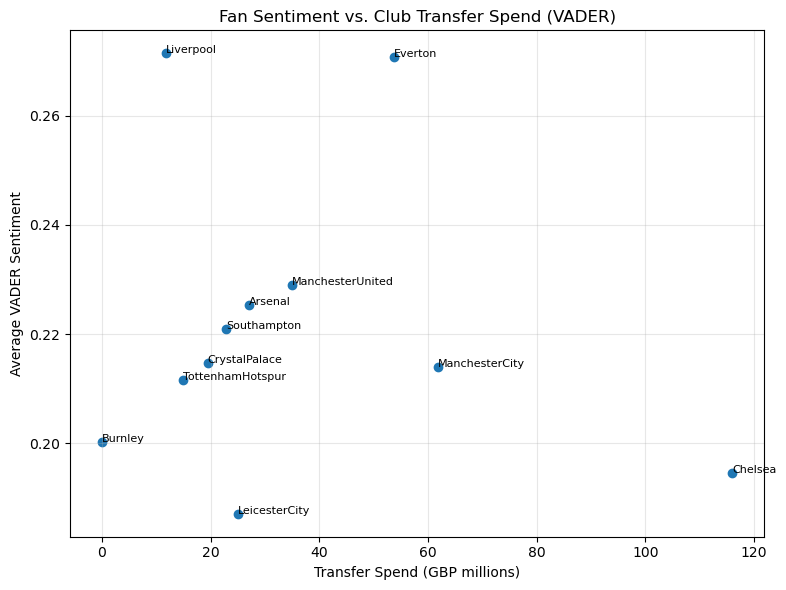

In [7]:
transfers_path = "pl_club_spend_2020-07-27_to_2020-09-11.csv"

if os.path.exists(transfers_path):
    spend = pd.read_csv(transfers_path)
    spend.columns = [c.strip().lower().replace(" ", "_") for c in spend.columns]
    spend = spend.rename(columns={"to_club": "club", "fee_clean_mgbp": "spend_gbp_m"})

    def canon(s):
        return re.sub(r'[^a-z0-9]+', '', str(s).lower())

    club_sent['_key'] = club_sent['club'].apply(canon)
    spend['_key'] = spend['club'].apply(canon)

    merged = pd.merge(
        club_sent,
        spend,
        on='_key',
        how='inner',
        suffixes=('', '_spend')
    )

    if 'club_spend' in merged.columns:
        merged['club'] = merged['club'].combine_first(merged['club_spend'])

    corr = merged[['avg_sentiment', 'spend_gbp_m']].corr(method='pearson').iloc[0, 1]
    print(f"\nCorrelation between transfer spend and average VADER sentiment: {corr:.3f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(merged['spend_gbp_m'], merged['avg_sentiment'])
    for _, r in merged.iterrows():
        plt.text(r['spend_gbp_m'], r['avg_sentiment'], r['club'], fontsize=8)
    plt.xlabel('Transfer Spend (GBP millions)')
    plt.ylabel('Average VADER Sentiment')
    plt.title('Fan Sentiment vs. Club Transfer Spend (VADER)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nCould not find club spend CSV to correlate with sentiment.")

# 7. Network centrality of clubs and fans

We compute:
- Degree centrality for clubs and fans,
- Weighted degree ("strength") for clubs,
- Fan degree/strength distributions.


Top clubs by degree centrality:
                club  degree_centrality  strength
6            Arsenal           0.219275     80172
9   ManchesterUnited           0.214808     78916
5          Liverpool           0.213400     74241
7     ManchesterCity           0.164830     50385
8   TottenhamHotspur           0.141005     45118
11           Everton           0.079096     35255
0            Chelsea           0.065009     22070
10     CrystalPalace           0.057521     21356
2      LeicesterCity           0.054327     20254
4        Southampton           0.028426      9456
3    AFC Bournemouth           0.023746      6144
1            Burnley           0.013041      3497

Fan degree stats:
Mean fan degree: 1.2742947941412457
Mean fan strength: 3.5090068121391376
Max fan strength: 3793


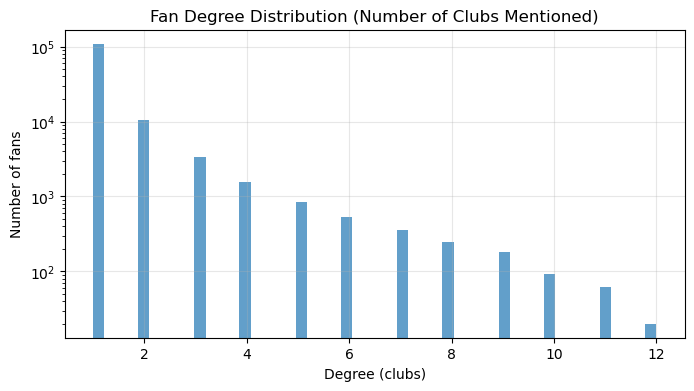

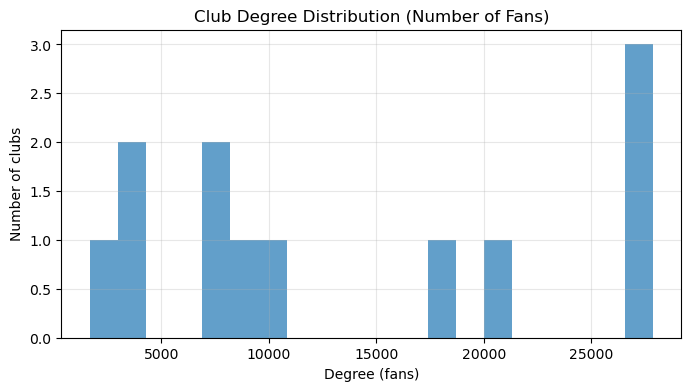

In [8]:
if len(G) == 0:
    raise ValueError("Graph G is empty. Make sure you built it from df first.")

deg_cent = nx.degree_centrality(G)
club_deg_cent = {c: deg_cent[c] for c in clubs}
club_strength = dict(G.degree(clubs, weight='weight'))

club_centrality_df = pd.DataFrame({
    "club": list(clubs),
    "degree_centrality": [club_deg_cent[c] for c in clubs],
    "strength": [club_strength[c] for c in clubs],
}).sort_values("degree_centrality", ascending=False)

print("\nTop clubs by degree centrality:")
print(club_centrality_df)

fan_deg_cent = {f: deg_cent[f] for f in fans}
fan_strength = dict(G.degree(fans, weight='weight'))

fan_cent_df = pd.DataFrame({
    "fan": list(fans),
    "degree_centrality": [fan_deg_cent[f] for f in fans],
    "strength": [fan_strength[f] for f in fans],
})

fan_degrees = np.array([G.degree(f) for f in fans])
club_degrees = np.array([G.degree(c) for c in clubs])

print("\nFan degree stats:")
print("Mean fan degree:", fan_degrees.mean())
print("Mean fan strength:", np.mean(list(fan_strength.values())))
print("Max fan strength:", max(list(fan_strength.values())))

plt.figure(figsize=(8,4))
plt.hist(fan_degrees, bins=50, alpha=0.7)
plt.title("Fan Degree Distribution (Number of Clubs Mentioned)")
plt.xlabel("Degree (clubs)")
plt.ylabel("Number of fans")
plt.yscale('log')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.hist(club_degrees, bins=20, alpha=0.7)
plt.title("Club Degree Distribution (Number of Fans)")
plt.xlabel("Degree (fans)")
plt.ylabel("Number of clubs")
plt.grid(alpha=0.3)
plt.show()

# 8. VADER-based text analysis: positive vs negative words

We look at the most common words in clearly positive and clearly negative tweets
based on the original VADER sentiment.

Top words in positive tweets (VADER):


,word,count
0,mufc,34459
1,this,30771
2,with,30053
3,arsenal,28681
4,have,24119
5,that,20801
6,united,18959
7,will,18136
8,season,17872
9,from,16852



Top words in negative tweets (VADER):


,word,count
0,mufc,6991
1,this,5565
2,arsenal,5553
3,that,5244
4,with,4899
5,have,4184
6,players,3775
7,season,3486
8,will,3326
9,they,3219


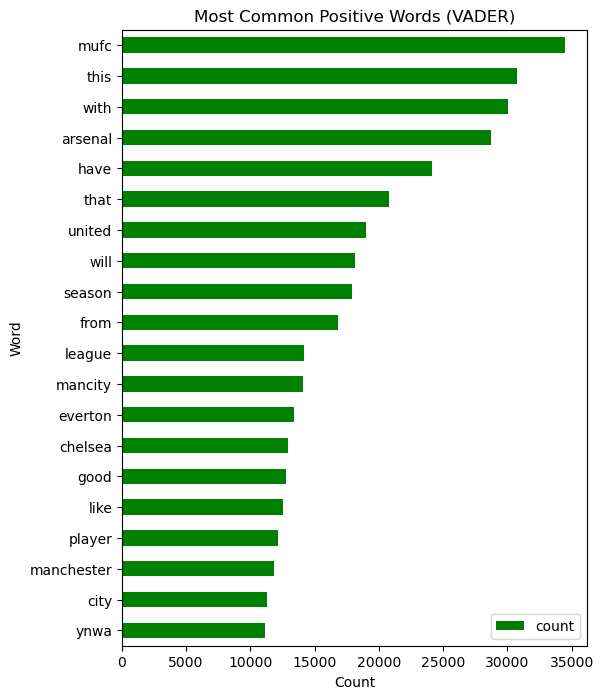

In [9]:
def simple_clean(text):
    text = text.lower()
    text = re.sub(r"http\S+","", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return text

df['clean_text'] = df['text'].astype(str).apply(simple_clean)

pos_tweets = df[df['sentiment'] > 0.4]['clean_text']
neg_tweets = df[df['sentiment'] < -0.4]['clean_text']

def top_words(series, n=20):
    counter = Counter()
    for line in series:
        for w in line.split():
            if len(w) > 3:
                counter[w] += 1
    return pd.DataFrame(counter.most_common(n), columns=['word','count'])

top_pos_words_vader = top_words(pos_tweets, n=20)
top_neg_words_vader = top_words(neg_tweets, n=20)

print("Top words in positive tweets (VADER):")
display(top_pos_words_vader)

print("\nTop words in negative tweets (VADER):")
display(top_neg_words_vader)

top_pos_words_vader.plot(kind='barh', x='word', y='count', figsize=(6,8), color='green')
plt.title("Most Common Positive Words (VADER)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


# 9. Self-made sentiment model (Logistic Regression on TF-IDF)

We now train our own sentiment classifier on the tweets.

Labels:
- positive: VADER sentiment > 0.2
- negative: VADER sentiment < -0.2
Neutral tweets are discarded from training.

Model:
- TF-IDF features (unigrams + bigrams),
- Logistic Regression classifier.

In [10]:
df_model = df.copy()
df_model = df_model[df_model["sentiment"].abs() > 0.2].copy()
df_model["label"] = (df_model["sentiment"] > 0.2).astype(int)

print("Training samples:", len(df_model))
print(df_model["label"].value_counts())

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    min_df=10,
    max_df=0.8,
    ngram_range=(1,2)
)

X = vectorizer.fit_transform(df_model["text"].astype(str))
y = df_model["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nSelf-made sentiment model performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))

Training samples: 267180
label
1    218784
0     48396
Name: count, dtype: int64

Self-made sentiment model performance:
Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      9722
           1       0.94      0.99      0.96     43714

    accuracy                           0.94     53436
   macro avg       0.93      0.85      0.88     53436
weighted avg       0.94      0.94      0.93     53436



# 10. Word importance in the self-made model

We inspect the logistic regression coefficients:
- Positive coefficients → words strongly associated with positive sentiment,
- Negative coefficients → words strongly associated with negative sentiment.

In [11]:
feature_names = np.array(vectorizer.get_feature_names_out())
coef = clf.coef_[0]

word_importance = pd.DataFrame({
    "word": feature_names,
    "coef": coef
})

top_pos_words_ml = word_importance.sort_values("coef", ascending=False).head(25)
top_neg_words_ml = word_importance.sort_values("coef", ascending=True).head(25)

print("Top positive words (ML model):")
display(top_pos_words_ml)

print("\nTop negative words (ML model):")
display(top_neg_words_ml)

Top positive words (ML model):


,word,coef
7228,best,14.079153
22977,great,11.934844
55201,united,11.548488
32139,love,11.266974
58028,win,10.595942
20742,free,10.246931
22494,good,8.912331
7425,better,8.722919
23753,happy,8.557630
57570,welcome,8.492469



Top negative words (ML model):


,word,coef
43515,rejected,-12.624340
58951,worst,-10.369561
26140,injury,-10.021486
47688,shit,-9.793327
20997,fuck,-9.367411
24234,hell,-9.291012
19475,ffs,-8.813512
23959,hate,-8.338070
5682,attacker,-8.228392
6659,battle,-8.123458


# 11. Add self-made sentiment scores to all tweets

We predict the probability that each tweet is positive (label=1).
This becomes our self-made sentiment score `sentiment_ml` in [0,1].

In [12]:
df['text'] = df['text'].astype(str)
X_all = vectorizer.transform(df['text'])
df['sentiment_ml'] = clf.predict_proba(X_all)[:,1]

print("\nCorrelation between VADER sentiment and ML sentiment:")
print(df["sentiment"].corr(df["sentiment_ml"]))

df[['text','sentiment','sentiment_ml']].head()


Correlation between VADER sentiment and ML sentiment:
0.7367598241112594


,text,sentiment,sentiment_ml
3400,£50 million for Chilwell? £90 million for Have...,0.7476,0.858620
3401,"Which #Chelsea player, past or present is this...",0.0000,0.857420
3402,AC Milan are getting closer to Tiemoué Bakayok...,0.8176,0.983652
3403,This is a brilliant 3 minute insight from the ...,0.8176,0.979351
3404,#InterMilan boss #AntonioConte makes N’Golo Ka...,0.0000,0.752090


# 12. Compare ML sentiment vs VADER at the word level

We merge our ML coefficients with the VADER lexicon and
look at words where they disagree the most.

In [13]:
vader = SentimentIntensityAnalyzer()
vader_lex = vader.lexicon
vader_df = pd.DataFrame(vader_lex.items(), columns=["word","vader_score"])

ml_vs_vader = word_importance.merge(
    vader_df,
    on="word",
    how="inner"
)

ml_vs_vader["difference"] = ml_vs_vader["coef"] - ml_vs_vader["vader_score"]

print("Words the ML model sees as much more positive than VADER:")
display(ml_vs_vader.sort_values("difference", ascending=False).head(20))

print("\nWords the ML model sees as much more negative than VADER:")
display(ml_vs_vader.sort_values("difference").head(20))

Words the ML model sees as much more positive than VADER:


,word,coef,vader_score,difference
179,best,14.079153,3.2,10.879153
1706,united,11.548488,1.8,9.748488
796,great,11.934844,3.1,8.834844
1071,love,11.266974,3.2,8.066974
724,free,10.246931,2.3,7.946931
1775,win,10.595942,2.8,7.795942
783,good,8.912331,1.9,7.012331
998,join,8.146658,1.2,6.946658
181,better,8.722919,1.9,6.822919
882,hope,8.489071,1.9,6.589071



Words the ML model sees as much more negative than VADER:


,word,coef,vader_score,difference
1337,rejected,-12.624340,-2.3,-10.324340
954,injury,-10.021486,-1.8,-8.221486
1801,worst,-10.369561,-3.1,-7.269561
1464,shit,-9.793327,-2.6,-7.193327
747,fuck,-9.367411,-2.5,-6.867411
165,battle,-8.123458,-1.6,-6.523458
1038,leaked,-7.677575,-1.3,-6.377575
1468,shock,-7.961994,-1.6,-6.361994
130,attacking,-8.121302,-2.0,-6.121302
686,ffs,-8.813512,-2.8,-6.013512


# 13. Club-level sentiment: ML vs VADER

We compute average sentiment per club using:
- VADER (`sentiment`),
- Our self-made model (`sentiment_ml`), and compare them.


Club sentiment based on self-made model:
                club  tweets  avg_sentiment_ml  avg_retweets
1            Arsenal   79993          0.796925    201.126049
9   ManchesterUnited   78916          0.771316    320.193700
7          Liverpool   74239          0.814403    133.192204
8     ManchesterCity   50385          0.797009    450.954133
11  TottenhamHotspur   45118          0.794007    275.350060
5            Everton   35186          0.819265    106.048428
3            Chelsea   21931          0.794854    135.298390
4      CrystalPalace   21356          0.794778    116.098989
6      LeicesterCity   20254          0.785171    121.808680
10       Southampton    9456          0.817676     39.965842
0    AFC Bournemouth    6144          0.802768     22.740723
2            Burnley    3497          0.793943      8.164999

Club-level sentiment comparison (ML - VADER rescaled):


,club,tweets,avg_sentiment_ml,avg_retweets,avg_sentiment_vader,vader_rescaled,diff_ml_minus_vader
9,Southampton,9456,0.817676,39.965842,0.220887,0.610443,0.207233
6,Chelsea,21931,0.794854,135.298390,0.194625,0.597313,0.197542
11,Burnley,3497,0.793943,8.164999,0.200182,0.600091,0.193852
8,LeicesterCity,20254,0.785171,121.808680,0.187106,0.593553,0.191618
3,ManchesterCity,50385,0.797009,450.954133,0.213904,0.606952,0.190057
4,TottenhamHotspur,45118,0.794007,275.350060,0.211563,0.605781,0.188225
7,CrystalPalace,21356,0.794778,116.098989,0.214788,0.607394,0.187384
0,Arsenal,79993,0.796925,201.126049,0.225329,0.612665,0.184261
5,Everton,35186,0.819265,106.048428,0.270679,0.635339,0.183925
10,AFC Bournemouth,6144,0.802768,22.740723,0.243267,0.621634,0.181134


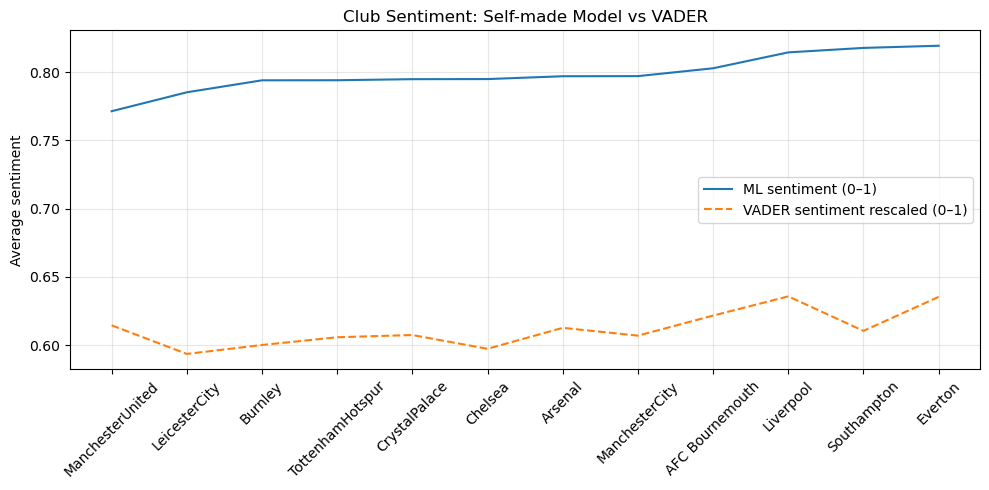

In [14]:
club_sent_ml = df.groupby('club', as_index=False).agg(
    tweets=('text', 'count'),
    avg_sentiment_ml=('sentiment_ml', 'mean'),
    avg_retweets=('retweets', 'mean')
).sort_values('tweets', ascending=False)

print("\nClub sentiment based on self-made model:")
print(club_sent_ml.head(12))

club_sent_vader = df.groupby('club', as_index=False)['sentiment'].mean().rename(columns={'sentiment':'avg_sentiment_vader'})

club_compare = club_sent_ml.merge(club_sent_vader, on='club')
# Rescale VADER from [-1,1] to [0,1] to compare with ML probabilities
club_compare['vader_rescaled'] = (club_compare['avg_sentiment_vader'] + 1) / 2
club_compare['diff_ml_minus_vader'] = club_compare['avg_sentiment_ml'] - club_compare['vader_rescaled']

print("\nClub-level sentiment comparison (ML - VADER rescaled):")
display(club_compare.sort_values('diff_ml_minus_vader', ascending=False))

plt.figure(figsize=(10,5))
clubs_sorted = club_compare.sort_values('avg_sentiment_ml')['club']

plt.plot(clubs_sorted, club_compare.set_index('club').loc[clubs_sorted, 'avg_sentiment_ml'],
         label='ML sentiment (0–1)')
plt.plot(clubs_sorted, club_compare.set_index('club').loc[clubs_sorted, 'vader_rescaled'],
         label='VADER sentiment rescaled (0–1)', linestyle='--')

plt.xticks(rotation=45)
plt.ylabel("Average sentiment")
plt.title("Club Sentiment: Self-made Model vs VADER")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 14. Most positive/negative tweets according to the self-made model

In [15]:
top_pos_ml = df.sort_values('sentiment_ml', ascending=False)[
    ['club','user','text','retweets','sentiment_ml']
].head(20)

top_neg_ml = df.sort_values('sentiment_ml', ascending=True)[
    ['club','user','text','retweets','sentiment_ml']
].head(20)

pd.set_option('display.max_colwidth', None)
print("Most positive tweets according to self-made model:")
display(top_pos_ml)

print("\nMost negative tweets according to self-made model:")
display(top_neg_ml)

Most positive tweets according to self-made model:


,club,user,text,retweets,sentiment_ml
411808,Arsenal,𝗖𝗵𝗲𝘆𝗣𝗼𝗹𝗮𝗿,@WinderDad I’m good thanks! Hope you’re well! #coyg,0,0.999998
293921,Liverpool,Nao,"I have to say I really truly am grateful to meet awesome #LFC 🔴friends🔴 U guys are super witty intelligent funny smart nice good hearted great spirit just the list goes on!! Thank u for making me laugh and share the moments, 🔴🤣👍 The best club 🔴 the greatest fans #LFC https://t.co/CjXOS4wgCX",0,0.999998
791378,Liverpool,Kevin Taylor,"@J_Smith55 Good owner, great staff working for the club, great ground, huge support, the best manager, a squad that has won so much, still ambitious, wonderful times. #YNWA",0,0.999997
289769,Liverpool,niran. 🇺🇸,"Overall, everyone go wish @TheOfficialFNG a happy 23rd birthday, he deserves all the best he can get! Thank you all and I hope you have a great night. #forzaniran #ynwa",2,0.999996
64808,Liverpool,ㅆ,RT @Normsi2: @JHenderson @officialAL20 This is so special #JH14 ❤ Wishing #AL14 all the best! Great number that 1️⃣4️⃣ Hope his future is a…,1,0.999991
235927,Liverpool,Takalani Lufhugu Jr.,@Cfa89 Happy Birthday Red. Hope you had a lovely one 🍰🎂🎊... #YNWA,1,0.999990
325042,Arsenal,ben goshorn,RT @andrew_the_pom: Unashamedly posting this again cos I love puns and I'm proud of this one... Love you @Aubameyang7 .. hope you're stayin…,1,0.999990
547805,Arsenal,Ahmed,"August 30th was my birthday and I received the best gift ever, thank you ARSENAL you made me happy, you're my first love, I loved you since 2005 and this love will be forever one and only. we will be better together. #COYG Credit for @ThierryHenry @cesc4official @Arsenal https://t.co/t1MD9l7ABC",0,0.999988
277101,Liverpool,♍NORMA❤GB🎹⫩💚LFC❤,@JHenderson @officialAL20 This is so special #JH14 ❤ Wishing #AL14 all the best! Great number that 1️⃣4️⃣ Hope his future is a very Bright-on(e) #YNWA ❤ https://t.co/BOpBKXGll1,1,0.999987
527653,Liverpool,Davinlan Vos - LFC Champ19ns❤️,"@Thokobaby1 @Bobby4Ballondor @DarkSideKopite @bmkbrunner @adamjoh36211398 @DoopLfc @FardielFma @Galv_LFC @hklLFC @INKLFC @jplfc2 @KtfLfc @LFC_PATH @LFC_Rodney @lfc_watch @LfcAsim @Thokobaby1 Thanks for S/O nice one 👍 appreciated 👊🏼 Morning reds ❤️ Hope everyone had a good week, wishing you all an awesome, chilled, relaxed fun filled weekend - enjoy. Keep safe &amp; well. Take care. #champions #winners #legends #YNWA #LFC #LFCFamily #Unbearables #Klopp https://t.co/gFJ4aOzg1q",0,0.999986



Most negative tweets according to self-made model:


,club,user,text,retweets,sentiment_ml
605934,CrystalPalace,Paul Ashby,"Oh ffs, it's gone from kit hate to wilf hate now. Fuck our lot are temperamental, #cpfc",1,0.000052
41609,ManchesterCity,Ryan #Mcfc,No shit. Ffs. 🤦🏽‍♂️🤣 #MCFC https://t.co/HmeuynTaMZ,0,0.000053
194743,ManchesterUnited,Kuro Ansokubi,Fuck this shit. Fuck everything. #mufc https://t.co/XYeXBXo85m,0,0.000059
578639,TottenhamHotspur,Suhel Ahmed,"Spurs Twitter has been unbearable for last two days and nights...fuck me, trust me to stuck indoors!! I hate it around this time...at least I could have been out and avoid this shit. Unfortunately stuck with nothing to do so keep browsing this shit! #COYS #THFC #StuckInDoors",0,0.000066
556674,Liverpool,Sir Nobody,"Can we jus cancel international football now...sooo shit. I hate that #lfc have so many english players, they risk injury for this dead-ass team and tournament. #ICEENG",1,0.000119
36086,ManchesterUnited,Steven Russell,Low and behold the window is a shambles again getting tired of this shit every fucking summer now piss poor #MUFC,0,0.000155
561176,TottenhamHotspur,Mark |/,How the actual hell are we losing to shit Watford?! #THFC,0,0.000156
123482,ManchesterCity,왕감자,"Fuck me, that was awful #mcfc",0,0.000163
72568,Liverpool,Paul Deaney,@Scouse1da It's so shit and only going to get worse !!#YNWA,0,0.000187
149800,Liverpool,Craig,"@JackSear Unfortunately another reason why Shaq has to be sold.. His injury record is awful, such a shame 😢 #YNWA",0,0.000264


# 15. Transfer spend vs sentiment (self-made model)

We redo the spend-vs-sentiment analysis with our ML sentiment
instead of the original VADER sentiment.

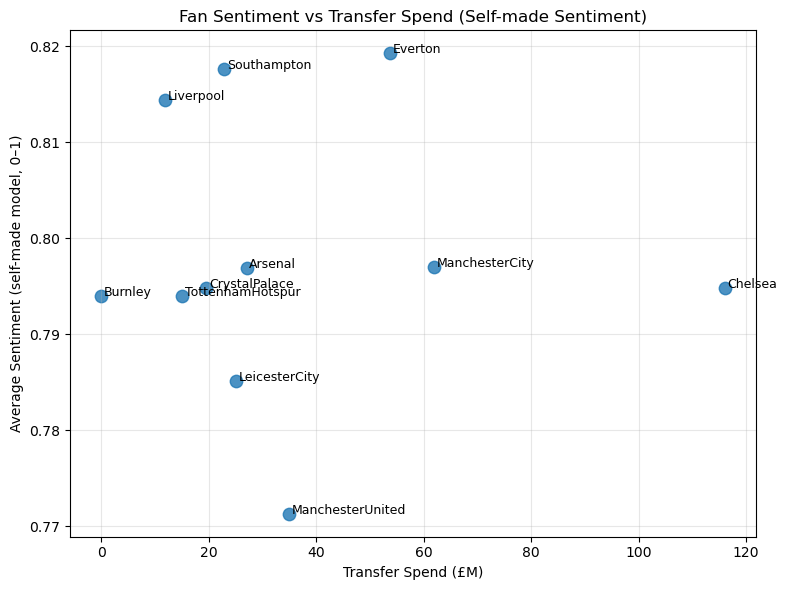

Correlation (self-made sentiment vs spend): -0.021


In [17]:
club_sent_ml_small = club_sent_ml[['club','avg_sentiment_ml']]

merged_ml = merged.merge(club_sent_ml_small, on='club', how='left')

plt.figure(figsize=(8,6))
plt.scatter(merged_ml['spend_gbp_m'], merged_ml['avg_sentiment_ml'], s=80, alpha=0.8)
for _, row in merged_ml.iterrows():
    plt.text(row['spend_gbp_m']+0.5, row['avg_sentiment_ml'], row['club'], fontsize=9)

plt.xlabel("Transfer Spend (£M)")
plt.ylabel("Average Sentiment (self-made model, 0–1)")
plt.title("Fan Sentiment vs Transfer Spend (Self-made Sentiment)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

corr_ml = merged_ml['spend_gbp_m'].corr(merged_ml['avg_sentiment_ml'])
print("Correlation (self-made sentiment vs spend):", round(corr_ml, 3))

# 16. Temporal dynamics with self-made sentiment

We compute daily average sentiment per club using our model and
plot time series for the top-spending clubs.

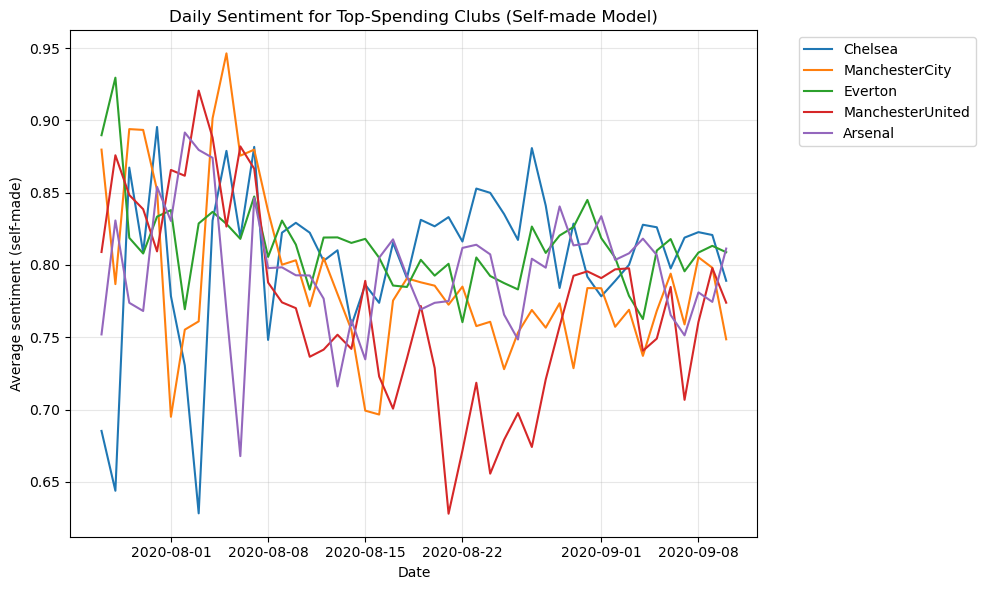

In [18]:
df['day'] = df['date'].dt.date

daily_sent_ml = df.groupby(['club','day'])['sentiment_ml'].mean().reset_index()

top_spenders = merged.sort_values('spend_gbp_m', ascending=False)['club'].head(5).tolist()

plt.figure(figsize=(10,6))
for club_name in top_spenders:
    sub = daily_sent_ml[daily_sent_ml['club'] == club_name]
    plt.plot(sub['day'], sub['sentiment_ml'], label=club_name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Date")
plt.ylabel("Average sentiment (self-made)")
plt.title("Daily Sentiment for Top-Spending Clubs (Self-made Model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()